# Numerics for two receptor model 

## Dependencies

In [2]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib as mpl
import pandas as pd

## PARAMETER INITIALISATION (from Suppl. Table 2 & 3)

In [12]:
# free ligand production rate at source in nM/s
J = 0.3 
#receptor production rate in nM.um/s
JR = 2.6e-3 
#transfer coefficient to heamolymph ( in s^{-1})
kappa_H = 0.075 
# area fraction of intercellular space at tissue haemo. interface
phi = 0.012 
# height and width of tissue in um
H = 53.; w=100 
# half-length of source and length of tissue
l = 26/2.; L = 116 
#number of points on the grid [l,L]
Ngrid = 200 
#diffusion coefficient of free ligand, here for GFP dimer (in um^2/s)
D0 = 21./(2.**(1./3.)); 
#diffusion constant of GPI-anchored receptor (in um^2/s)
Dr = 0.1
#typical width of intercellular space (in um)
h = 0.02
#geometric factor for increase in binding rate due to proximity
g = 100.

# parameters for high-affinity receptors (SR)
konA = 7.7*10**-4;
koffA = 1.7*10**-4;

# parameters for low affinity receptors (NR)
konB = 2*10**-3;
koffB = 5*10**-2;

#degradation rate of signalling configuration
kint_signal = 2.1*10**-3
#degradation rate of non-signalling configurations 
kint = JR / 100.; #2.6*10**-5;
#parameter used to modify internalisation rate of single-bound config in monomer case
monomer_modifier = 1.
# rescaled degradation rate in hemolymph (in s^{-1})
KH_bar = 0.01 

# volume of hemolymph
Vh = 1e8 
# inferred from KH_bar for given Vh 
#(specific choice of Vh only affects time to st.st.)
KH = KH_bar * (2*phi*w*H*L) / Vh 
# time-rescaling factor to speed up hemolymph dynamics 
#(does not affect steady state)
effective_vh_scaling = 100 
#suppression factor for permeability of NR into haemolymph
psi = 0
#multiplicity of binding sites for ligand (m=1 for monomer, m=2 for dimer)
m=2.

## Discrete operators and lattice specifications

In [4]:
#discrete laplacian operator to use for diffusion terms
discr_lap = np.zeros((Ngrid,Ngrid))
discr_lap += np.diag(np.full(Ngrid,-2))
discr_lap[0,0]=-1
discr_lap[-1,-1]=-1
discr_lap += np.diag(np.full(Ngrid-1,1),k=1)
discr_lap += np.diag(np.full(Ngrid-1,1),k=-1)


#spatial coordinates of integration intervals
xcoord = np.linspace(0, L+l, Ngrid) - l; 
dx = xcoord[1]-xcoord[0]
xcoord_vels = xcoord * np.heaviside(xcoord,0)
indicator_source = 1 - np.heaviside(xcoord,0)
production_array = np.full(len(xcoord),1)

## Model dynamics (function definitions) - data generation and plotting

In [23]:
def odefunction(y,t,jrB,jrA,j_vec,hnd,psi):
    
    ''' 
    This function defines the dynamics of the model.
    It is fed into scipy.integrate to generate data. 
     
    Arguments:
    jrB = NR production rate
    jrA = SR production rate
    j_vec = ligand production rate of different discretised sections of tissue 
    hnd = can be used to prevent formation of SR-NR complex (if set to zero)
    psi = can be tuned to control NR leakage (no leakage if  psi=0)
    
    '''
    
    # retrieve distinct concentrations from full state vector
    c = y[:Ngrid]
    nf_A = y[Ngrid:2*Ngrid]
    nb_A = y[2*Ngrid:3*Ngrid]
    nb_AA = y[3*Ngrid:4*Ngrid]
    nf_B = y[4*Ngrid:5*Ngrid]
    nb_B = y[5*Ngrid:6*Ngrid]
    nb_BB = y[6*Ngrid:7*Ngrid]
    nb_AB = y[7*Ngrid:8*Ngrid]
    c_hae = y[-1]
    
    # terms that repeat - only calculate once for convenience
    #Suppl.Eq. 76
    r_0_A = m * konA * nf_A * c - koffA * nb_A 
    #Suppl.Eq. 77
    r_0_B = m * konB * nf_B * c - koffB * nb_B 
    #Suppl.Eq. 78
    r_A_AA = g * konA * nb_A * nf_A - koffA * nb_AA 
    #Suppl.Eq. 79
    r_B_BB = g * konB * nb_B * nf_B - koffB * nb_BB 
    #Suppl.Eq. 80
    r_A_AB = hnd * (g * konB * nb_A * nf_B - koffB * nb_AB) 
    #Suppl.Eq. 81
    r_B_AB = hnd * (g * konA * nf_A * nb_B - koffA * nb_AB) 
    
    # increments of individual concentrations as defined in the model
    #Suppl.Eq. 67
    c_dt = (j_vec - kappa_H * (c-c_hae) 
            + D0/(dx**2) * discr_lap.dot(c) 
            - r_0_A / h - r_0_B / h )
    #Suppl.Eq. 69
    nf_A_dt = -r_0_A - r_A_AA - kint * nf_A - r_B_AB  + jrA * production_array 
    #Suppl.Eq. 70   
    nb_A_dt = r_0_A - r_A_AA - r_A_AB  - kint * nb_A * monomer_modifier
    #Suppl.Eq. 71  
    nb_AA_dt = r_A_AA - kint_signal * nb_AA                          
    #Suppl.Eq. 72
    nf_B_dt = -r_0_B - kint * nf_B + jrB - r_B_BB - r_A_AB + Dr/(dx**2)*discr_lap.dot(nf_B) 
    #Suppl.Eq. 73
    nb_B_dt = r_0_B - r_B_BB - r_B_AB  - kint * nb_B + Dr/(dx**2)*discr_lap.dot(nb_B) 
    #Suppl.Eq. 74
    nb_BB_dt = r_B_BB - kint * nb_BB + Dr/(dx**2)*discr_lap.dot(nb_BB) 
    #Suppl.Eq. 75
    nb_AB_dt = r_A_AB + r_B_AB  - kint * nb_AB
    #Suppl.Eq. 68
    c_hae_dt = effective_vh_scaling * KH * ( kappa_H/KH_bar *  np.mean(c - c_hae) - c_hae ) 
    
    update_array = np.zeros(8*Ngrid + 1)
    update_array[:Ngrid] = c_dt
    update_array[Ngrid:2*Ngrid] = nf_A_dt
    update_array[2*Ngrid:3*Ngrid] = nb_A_dt
    update_array[3*Ngrid:4*Ngrid] = nb_AA_dt
    update_array[4*Ngrid:5*Ngrid] = nf_B_dt
    update_array[5*Ngrid:6*Ngrid] = nb_B_dt
    update_array[6*Ngrid:7*Ngrid] = nb_BB_dt
    update_array[7*Ngrid:8*Ngrid] = nb_AB_dt
    update_array[-1] = c_hae_dt
    
    return update_array


def single_run(jrB,jrA,j,hnd,psi,meas_time):    
    ''' This function returns a single realisation of the model evolved from 
    zero ligand initial condition to its (numerical steady) state after meas_time/3600 hours.
    The function also generates some concentration plots to analyse the outcome.
    Returns the concentration profile of SR-GFP-SR signalling complexes as a 1d array.
    
     Arguments:
    jrB = NR production rate
    jrA = SR production rate
    j = ligand production rate
    hnd = can be used to prevent formation of SR-NR complex (if set to zero)
    psi = can be tuned to control NR leakage (no leakage if  psi=0)
    meas_time = total simulation time (in seconds)'''
    
    t_steps = 100 
    t = np.linspace(0, meas_time,  t_steps)  

    y0=np.zeros((8*Ngrid+1))
    y0[4*Ngrid:5*Ngrid]=np.full(Ngrid,jrB/kint);
    j_vec = np.zeros(Ngrid); j_vec[:int(l/dx)] = np.full(int(l/dx),j)
    
    tol=10**-6
    X, infodict = integrate.odeint(odefunction,
                                   y0,
                                   t,
                                   args=(jrB,jrA,j_vec,hnd,psi),
                                   full_output=True,rtol=tol, atol=tol)
    infodict['message']
    
    c = X[-1, :Ngrid]
    nf_A = X[-1, Ngrid:2*Ngrid]
    nb_A = X[-1, 2*Ngrid:3*Ngrid]
    nb_AA = X[-1, 3*Ngrid:4*Ngrid]
    #nf_B = X[-1, 4*Ngrid:5*Ngrid]
    nb_B = X[-1, 5*Ngrid:6*Ngrid]
    nb_BB = X[-1, 6*Ngrid:7*Ngrid]
    nb_AB = X[-1, 7*Ngrid:8*Ngrid]
    c_hae = X[:, -1]
    
    nb_AA_relaxation = X[:, 3*Ngrid:4*Ngrid][:, 0:Ngrid:20]

    # plot of signalling complex concentration gradient
    plt.figure(1)
    plt.plot(xcoord, nb_AA)
    plt.vlines(0, 0, np.max(nb_AA), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('SR-GFP-SR concentration [nM $\mu$m]')
    
    # plot of once-bound SR concentration
    plt.figure(2)
    plt.plot(xcoord,nb_A)
    plt.vlines(0, 0, np.max(nb_A), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('SR-GFP concentration [nM $\mu$m]')
    
    # plot of twice-bound NR concentration
    plt.figure(3)
    plt.plot(xcoord,nb_BB)
    plt.vlines(0, 0, np.max(nb_BB), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('NR-GFP-NR concentration [nM $\mu$m]')
    
    # plot of once-bound NR concentration
    plt.figure(4)
    plt.plot(xcoord, nb_B)
    plt.vlines(0, 0, np.max(nb_B), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('NR-GFP concentration [nM $\mu$m]')
    
    # plot of NR-GFP-SR concentration
    plt.figure(5)
    plt.plot(xcoord,nb_AB)
    plt.vlines(0,0,np.max(nb_AB),linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('NR-GFP-SR concentration [nM $\mu$m]')
    
    # plot of unbound SR concentration
    plt.figure(6)
    plt.plot(xcoord, nf_A)
    plt.vlines(0,0,np.max(nf_A),linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('free SR concentration [nM $\mu$m]')
    
    
    # plot of free ligand concentration
    plt.figure(7)
    plt.plot(xcoord,c)
    plt.vlines(0,0,np.max(c),linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('Free GFP concentration [nM]')
    
    # time curves of signalling intensity at representative positions
    plt.figure(8)
    for k in range(10):
        plt.plot(np.arange(0,t_steps,1),nb_AA_relaxation[:,k])
    plt.xlabel('Time elapsed from initialisation [a.u.]')
    plt.ylabel('SR-GFP-SR concentration')
    
    # fluorescence of bound vs free GFP
    plt.figure(9)
    fluor_tot = (nb_A + nb_AA + nb_B + nb_BB + nb_AB)/h
    plt.semilogy(xcoord,fluor_tot)
    plt.semilogy(xcoord,c)
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('Bound vs free GFP concentration [nM]')
    
    
    return nb_AA

def values_for_phase(high_t,low_t,jrB,jrA,j,hnd,psi,meas_time):
    
    '''
    Function used to populate phase diagrams in Figure 5C in a parallel fashion. In addition to the usual model 
    parameters (e.g. binding and degradation rates), it also takes two concentrations (high_t and low_t) which
    we choose as representative of the high-target and low-target signaling levels, respectively.
    
    The function returns a sequence of 6 values, which are appended to "param_map.txt" as a single line.
    
    The values correspond to, in order:
    (1) SR production rate
    (2) NR production rate
    (3) Furthest point from AP boundary at which the signaling gradient crosses high_t (as a distance from the 
        source-tissue boundary, in um). 
        If signaling level is higher than high_t everywhere (full activation), returns 1000. 
        If signaling level is lower than high_t everywhere outside the source (no activation), returns -1000.
    (4) Furthest point from AP boundary at which the signaling gradient crosses low_t (as a distance from the 
        source-tissue boundary, in um).
        If signaling level is higher than low_t everywhere (full activation), returns 1000.
    (5) Signaling level at the end of the tissue (furthest point from source-tissue boundary).
        This value is indicative of the background signaling level due to ligand flow from the hemolymph.
    (6) Boolean flag to detect whether high_t is crossed twice, which happens for activation in a stripe.
        If flag=0, high_t is crossed once (or never). If flag=1, high_t is crossed twice (stripe activation). 
    
    '''
    

    outputs = np.array([float(-1000),float(1000),float(1000),float(0.0)])
    nbhh_profile = single_run(jrB,jrA,j,hnd,psi,meas_time)
    
    for kk in range(len(nbhh_profile)):
        
        if nbhh_profile[-(kk+1)] > high_t:
            if kk == 0: #meaning lowest value is already larger than high level target
                outputs[0] = 1000
                break 
            elif (xcoord[-(kk+1)+1] + xcoord[-(kk+1)])/2. < 0.: #meaning the condition is satisfied inside the source
                break #keep -1000 as output
            else:
                outputs[0] = (xcoord[-(kk+1)+1] + xcoord[-(kk+1)])/2.
                break
    
    for nn in range(len(nbhh_profile)-1):
        if nbhh_profile[-(nn+1)] > high_t and nbhh_profile[-(nn+2)] < high_t:
            outputs[3] = 1.0
    
    for ll in range(len(nbhh_profile)):
        
        if nbhh_profile[-(ll+1)] > low_t:
            if ll == 0: #meaning the lowest value is already larger than low-level target (activated everywhere)
                break #i.e. keep 1000 as output
            else:
                outputs[1] = (xcoord[-(ll+1)+1] + xcoord[-(ll+1)])/2.
                break
        
    outputs[2] = nbhh_profile[-1]
    with open("param_map.txt","a") as myfile:
        myfile.write( str(jrA)+' '+str(jrB)+' '+str(outputs[0])+' '+str(outputs[1])+' '+str( outputs[2])+' '+str(outputs[3])+'\n' )
    return 

# Code to generate figures in manuscript
## Fig 5B

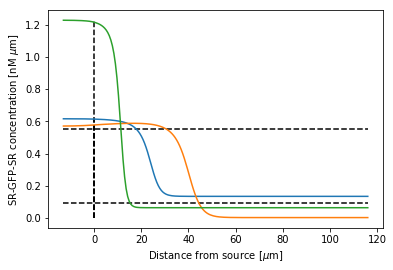

In [20]:
Dr = 0.1; g=100; m=2; monomer_modifier = 1.
single_run(jrB=0*JR, jrA=JR, j=J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=1*JR, jrA=JR, j=J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=0*JR, jrA=2*JR, j=J, hnd=1, psi=0, meas_time=200*3600);
plt.figure(1); plt.hlines([0.55,0.09],-13,116,linestyle='--') #high and low targets as defined in Fig5C

for fig_num in [2,3,4,5,6,7,8,9]: #only show relevant data
    plt.close(fig_num)

## Fig S13B

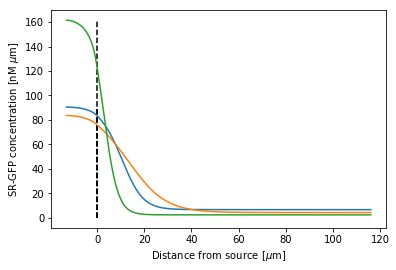

In [27]:
''' Fig S13 B'''
Dr = 0.1; g=0; m=2; monomer_modifier = 1.
single_run(jrB=0*JR, jrA=JR, j=J, hnd=0, psi=0, meas_time=200*3600);
single_run(jrB=1*JR, jrA=JR, j=J, hnd=0, psi=0, meas_time=200*3600);
single_run(jrB=0*JR, jrA=2*JR, j=J, hnd=0, psi=0, meas_time=200*3600);

for fig_num in [1,3,4,5,6,7,8,9]: #only show relevant data
    plt.close(fig_num)

## Fig5C

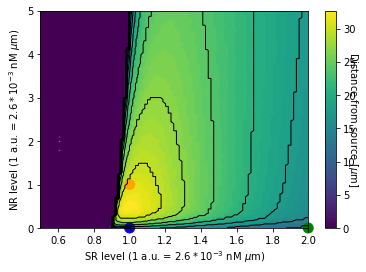

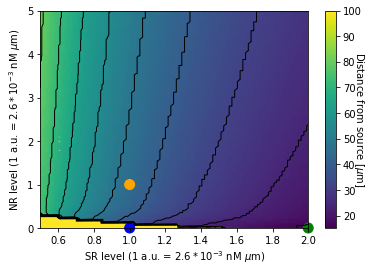

In [21]:
''' Fig 5 C,D'''
import pandas as pd
data = pd.read_csv('param_map_steady_F5C_dxFIX.txt', header = None, sep=" ")
plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[2],
            vmin=0,
            s=10)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,5))
cbar.set_label('Distance from source [$\mu$m]', rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[2]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],[0,1,0],c=['blue','orange','green'],s=100,clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[3],
            vmax=100,
            s=10)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,5))
cbar.set_label('Distance from source [$\mu$m]',
               rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[3]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],
            [0,1,0],
            c=['blue','orange','green'],
            s=100,
            clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

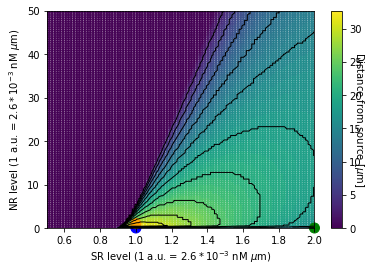

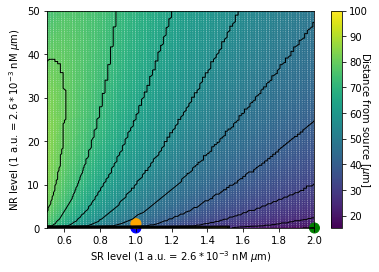

In [22]:
''' 
Replot phase diagrams as in Fig 5 C,D with extended NR range (note different data source 'param..._extendedNR...').
The extended range makes it more obvious that signalling is suppressed at high NR concentrations.
'''

import pandas as pd
data = pd.read_csv('param_map_steady_F5C_extendedNR_dxFIX.txt', header = None, sep=" ")
plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[2],
            vmin=0,
            s=4)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,50))
cbar.set_label('Distance from source [$\mu$m]', rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[2]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],[0,1,0],c=['blue','orange','green'],s=100,clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[3],
            vmax=100,
            s=4)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,50))
cbar.set_label('Distance from source [$\mu$m]',
               rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[3]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],
            [0,1,0],
            c=['blue','orange','green'],
            s=100,
            clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

The data for the above contour plots was generated by running the following script on the Crick computing cluster.

        #!/bin/bash
        #SBATCH -n 1 #number of processes
        #SBATCH --job-name=phaseF5C
        #SBATCH --time=30:00:00 #max runtime
        #SBATCH --array=1-9801 #number of parallel realisations
        param_store=$./parameter_list.txt

        ml Anaconda3

        jrA=$(cat $param_store | awk -v var=$SLURM_ARRAY_TASK_ID 'NR==var {print $1}')
        jrB=$(cat $param_store | awk -v var=$SLURM_ARRAY_TASK_ID 'NR==var {print $2}')   

        srun -n 1 -u launch_script.py  " $jrB "  " $jrA "

        echo "done"

with parameter_list.txt being a two-column table of receptor production generated via 

        #generate parameter table for phase plots S5C
        import numpy as np

        jrA_steps= np.linspace(0.5,2,99)
        jrB_steps=np.linspace(0,5,99)
        Args=[]
        for i in range(len(jrA_steps)) :
            for j1 in range(len(jrB_steps)):
                Args.append((jrA_steps[i],jrB_steps[j1]))
                test=np.array(Args);
        np.savetxt('parameter_list.txt', test, delimiter=' ',fmt='%1.6f')


and launch_script.py reading

        #!/usr/bin/env python2
        from SUBMISSION_spilling_source_degr_full_micro_2receptors import *
        import sys

        high_t = 0.55 #high target level
        low_t = 0.09  #low target level

        print(sys.argv[1],type(sys.argv[1]))

        jrB = 2.6e-3 * float(sys.argv[1])
        jrA = 2.6e-3 * float(sys.argv[2])

        j = 0.3
        hnd = 1.
        psi = 0
        meas_time = 200*3600

        values_for_phase(high_t,low_t,jrB,jrA,j,hnd,psi,meas_time)

## Fig S13D

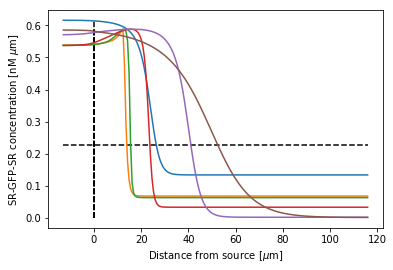

In [26]:
Dr = 0.1; g=100.; m=2.; monomer_modifier = 1.
nbaa = single_run(jrB=0*JR,
           jrA=JR,
           j=J,
           hnd=1,
           psi=0,
           meas_time=200*3600);
plt.figure(1);plt.hlines(nbaa[0]/np.e,-13,116,linestyle='--')

for Dr in [0.,0.001,0.01,0.1,1]:
    single_run(jrB=JR,
               jrA=JR,
               j=J,
               hnd=1,
               psi=0,
               meas_time=200*3600);
    
for fig_num in [2,3,4,5,6,7,8,9]: #only show relevant data
    plt.close(fig_num)

## Fig S13E

Calculate length scale for model with two receptors, based on Eq. 58 in the supplementary.

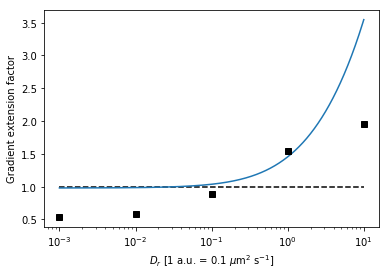

In [24]:
def S_extension(sigma):
    """ return l/l0 where l is the length scale of the gradient
    l0 is the reference length scale for jrb=0 (no second receptor)
    Dr is varied relative to 0.1um^2/s"""
    #receptor production, set equal for the two receptors
    jrB = JR
    jrA = JR
    #effective degradation rate for A and B
    kra = (konA * jrA) / (h * (kint_signal + koffA))
    krb = (konB * jrB) / (h * (kint + koffB))
    #sigma is factor that changes Dr relative to 0.1um^2/s
    #Drt is Dr/(kb+koffb)
    Drt = 0.1 * sigma / (kint + koffB)
    #coefficients in polynomial equation Eq. 58, for S=l/l0
    #with l0 = sqrt(D0/(kra+kappa_H))
    C1 = (kra  + krb  + kappa_H) * D0 **2 / (kra + kappa_H)**2
    C2 = (D0 + Drt * (kra + krb * (kint + koffB) / kint  + kappa_H)) * D0 / (kra + kappa_H)
    C3 = D0 * Drt
    #calculate the factor S
    return np.sqrt((C2 + np.sqrt(C2**2 - 4*C1*C3))/(2*C1))

plt.figure()
xs = [10**x for x in np.linspace(-3,1,10000)]
ys = np.array([S_extension(x) for x in xs])
plt.semilogx(xs,ys)
plt.hlines(1,
           1e-3,
           10,
           color='k',
           linestyle='dashed')
# plot values from full simulation
recept_diffs = [0.001, 0.01, 0.1, 1, 10]

ref_length = 26.7 #lengthscale of gradient without NR (blue in S13D), defined as 1/e decrease from max
extension_factors = [14.2 / ref_length,
                     15.6 / ref_length, 
                     23.6  /ref_length, 
                     41 / ref_length, 
                     52.2 / ref_length] #distances at which curves of increasing Dr cross dashed line in S13D, scaled
                    
    
plt.plot(recept_diffs,
         extension_factors,
         'ks')
plt.xlabel('$D_r$ [1 a.u. = 0.1 $\mu$m$^2$ s$^{-1}$]')
plt.ylabel('Gradient extension factor');

## Fig S5G

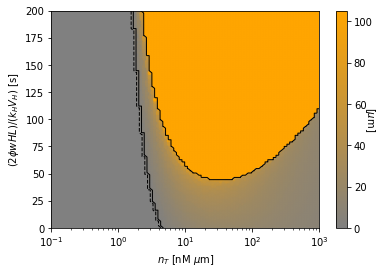

In [25]:
def discrim(x):
    if x < -900:
        return 'nan' 
    elif x > 900:
        return 'nan'
    else:
        return x

def discrim1(x):
    if x == -1000:
        return 'grey' 
    elif x == 1000:
        return 'grey'
    else:
        return 'grey'

def discrim2(x):
    if x == -1000:
        return 'grey' 
    elif x == 1000:
        return 'orange'
    else:
        return 'grey'

cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', 
                                             [(0,    'grey'),
                                              (1,    'Orange')], N=126)

plt.figure()
data = pd.read_csv('param_map_fast_dxFIX.txt',
                   header = None,
                   sep=" ")
plt.scatter(data[0]/kint,
            1./(data[1]*Vh/(2*phi*w*H*L)),
            c=[discrim1(x) for x in data[2]],
            s=10,
            vmin=-1100,
            vmax=0)
plt.scatter(data[0]/kint,1/(data[1]*Vh/(2*phi*w*H*L)),c=[discrim2(x) for x in data[2]],s=10,vmin=0,vmax=1000)
plt.scatter(data[0]/kint,1/(data[1]*Vh/(2*phi*w*H*L)),c=[discrim(x) for x in data[2]],s=10,vmin=0,cmap=cmap)

cbar = plt.colorbar(); cbar.set_label('[$\mu$m]', rotation=270)
plt.semilogx(); plt.xlabel('$n_T$ [nM $\mu$m]'); plt.ylabel('$(2 \phi w H L)/(k_H V_H)$ [s]')
plt.xlim((0.1,1000));
plt.ylim((0,200));
plt.semilogx()

plt.tricontour(data[0]/kint,
               1./(data[1]*Vh/(2*phi*w*H*L)),
               data[2],
               2,
               colors='k',
               vmax=1000,
               linewidths=1)

The data for this plot was generated with similar scripts to those available above for Fig. 5C, which were run on the Crick computing cluster. Specific parameters of the model (namely and g, m, D, kint_signal) where modified with respect to the above values to account for the dimer nature of the ligand, as explained in the figure legend and the discussed in the Supplementary Material.